In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds

In [4]:
# Load the dataset
ratings_df = pd.read_csv('/content/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
movies_df = pd.read_csv('/content/u.item', sep='|', encoding='latin-1', names=['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                                                                     'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
                                                                     'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                                                                     'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
ratings_df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
movies_df.head()

,item_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
ratings_df.isnull().sum()

,0
user_id,0
item_id,0
rating,0
timestamp,0


In [7]:
movies_df.isnull().sum()

,0
item_id,0
title,0
release_date,1
video_release_date,1682
IMDb_URL,3
unknown,0
Action,0
Adventure,0
Animation,0
Children,0


In [8]:
movies_df = movies_df.drop(columns=['video_release_date'])
movies_df = movies_df.dropna(subset=['IMDb_URL'])

In [9]:
movies_df.shape

(1679, 23)

In [10]:
# Step 2: Preprocess the data
user_item_matrix = ratings_df.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
user_item_matrix = user_item_matrix.values
user_ratings_mean = np.mean(user_item_matrix, axis=1)
user_item_matrix_normalized = user_item_matrix - user_ratings_mean.reshape(-1, 1)

# Split the data into training and testing sets
train_data, test_data, train_indices, test_indices = train_test_split(
    user_item_matrix_normalized, np.arange(user_item_matrix_normalized.shape[0]), test_size=0.2, random_state=42
)

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Training data shape: (754, 1682)
Testing data shape: (189, 1682)


In [11]:
# Split the user_ratings_mean into training and testing sets
train_user_ratings_mean = user_ratings_mean[train_indices]

# Step 3: Perform Matrix Factorization
U, sigma, Vt = svds(train_data, k=50)
sigma = np.diag(sigma)
predicted_ratings = np.dot(np.dot(U, sigma), Vt) + train_user_ratings_mean.reshape(-1, 1)

In [12]:
# Step 4: Evaluate the Model
test_data_flat = test_data[test_data.nonzero()].flatten()
predicted_ratings_flat = predicted_ratings[test_data.nonzero()].flatten()
rmse = np.sqrt(mean_squared_error(test_data_flat, predicted_ratings_flat))
print(f"RMSE: {rmse:.4f}")

RMSE: 1.0569


In [13]:
# Step 5: Generate Recommendations
def recommend_movies(user_id, num_recommendations=5):
    user_ratings = predicted_ratings[user_id - 1]
    top_movie_indices = np.argsort(user_ratings)[::-1][:num_recommendations]
    recommended_movies = movies_df.iloc[top_movie_indices]['title']
    return recommended_movies

user_id = 45
recommended_movies = recommend_movies(user_id)
print(f"Recommended movies for user {user_id}:")
print(recommended_movies)

Recommended movies for user 45:
0                Toy Story (1995)
286          Marvin's Room (1996)
99                   Fargo (1996)
483    Maltese Falcon, The (1941)
49               Star Wars (1977)
Name: title, dtype: object


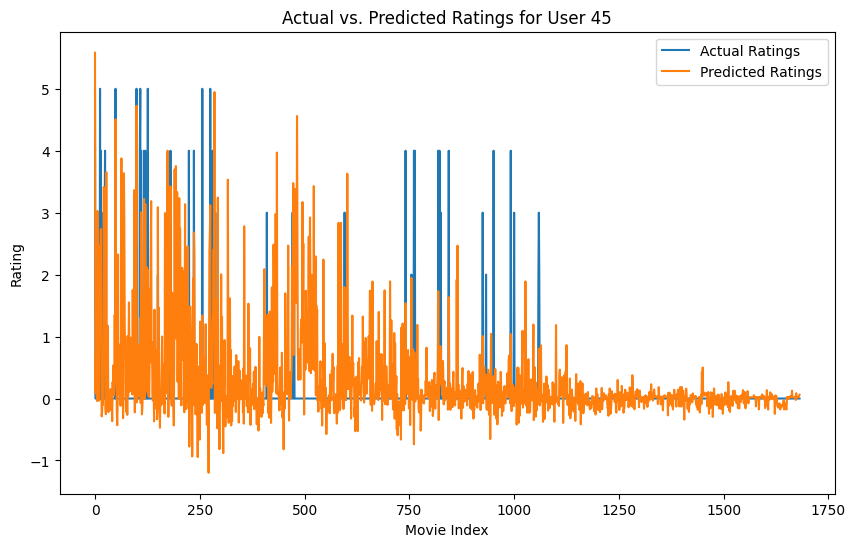

In [15]:
# Step 6: Visualize Results
sample_user_id = 45
sample_user_ratings = user_item_matrix[sample_user_id - 1]
sample_user_predicted_ratings = predicted_ratings[sample_user_id - 1]

plt.figure(figsize=(10, 6))
plt.plot(sample_user_ratings, label='Actual Ratings')
plt.plot(sample_user_predicted_ratings, label='Predicted Ratings')
plt.xlabel('Movie Index')
plt.ylabel('Rating')
plt.title(f'Actual vs. Predicted Ratings for User {sample_user_id}')
plt.legend()
plt.show()